# Expected Shortfall (ES) of returns series and backtesting (univariate) 
I use a **GJR-GARCH** model with **skewed-t** errors to estimate one-day ahead ES of univariate return series. Then, I evaluate this risk measure according to backtesting techniques.

## 1. Load and prepare the data

In [6]:
# libraires
library(pracma)
library(ggplot2)

In [2]:
stock <- "AAPL"

t1 <- as.integer(ISOdate(2016,1,17,hour=0))
t2 <- as.integer(ISOdate(2022,6,9,hour=0))

url <- paste("https://query1.finance.yahoo.com/v7/finance/download/",
             stock,
             "?period1=", 
             as.integer(t1),
             "&period2=",
             as.integer(t2),
             "&interval=1d&events=history&includeAdjustedClose=true",
             sep="")

# Downloading the .csv file:
data <- read.csv(url)
data['Date'] <- as.Date(data$Date)
pricesdf <- data.frame(date=data$Date, price=data$Adj.Close)

# Compute log-returns:
genretdf <- function(pricesdf) {
  prices <- data.matrix(pricesdf)
  ret <- 100*(diff(log(prices[,2:ncol(prices)])))  
  date <- as.Date(pricesdf$date[-1]) 
  retdf <- data.frame(date,ret)
  return(retdf)
  }

retdf <- genretdf(pricesdf)
tail(retdf)

,date,ret
,<date>,<dbl>
1604,2022-06-01,-0.08738184
1605,2022-06-02,1.66715234
1606,2022-06-03,-3.93185999
1607,2022-06-06,0.52140293
1608,2022-06-07,1.74330472
1609,2022-06-08,-0.50560480


## 2. ES (rolling window estimation)
### 2.1. GJR-GARCH
The most frequent procedure to estimate ES (and VaR) is to propose a parametric model, derive the ES (or VaR) implied by the parametric model, and then estimate the model parameters. In this exercise, I assume that returns $r_t$ follow a GJR-GARCH model with skewed-t errors, i.e., 
\begin{eqnarray} 
r_{t} &=& \mu + \sigma_{t} z_{t}\\ 
\sigma_{t}^2 &=&  \omega + \beta  \sigma_{t-1}^2 + \alpha (\sigma_{t-1} z_{t-1})^2 + \gamma (\sigma_{t-1} z_{t-1})^2 I_{\{z_{t-1}<0\}}
\end{eqnarray} where  
- $z_{t}$ is an i.i.d. random variable that follows a skewed-t of Hansen (1994) distribution, with degrees of freedom and asymmetry parameters  denoted by $2<\nu<\infty$ and $-1<\lambda<1$, respectively.
- $\mu$ denotes de unconditional mean.
- $\sigma_{t}^2$ corresponds to the conditional variance which describes a GJR-GARCH model.
- $I$ is an indicator function that takes the value of 1 if the inequality is satisfied and 0 otherwise.
- Positiveness restrictions: $\omega>0$, $\alpha\geq 0$, $\alpha+\gamma>0$ and $\beta\geq 0$. 
- Stationarity restriction:  $\alpha+\frac{1}{2}\gamma+\beta<1$.

There are 7 parameters to be estimated, e.g., $\theta:=(\mu, \omega, \beta, \alpha, \gamma,\nu,\lambda)$.

### 2.2. ES (closed formula)
For a given $\alpha\in(0,1)$, the $\alpha$-level ES at time $t$ is defined as:
\begin{equation} 
ES_t(\alpha)=\mathbb{E}\left(r_t|r_t\leq\text{VaR}_{t}(\alpha)\right), \\
\end{equation}
where $\text{VaR}_{t}(\alpha)$ denotes the value-at-risk (e.g., $\alpha$-quantile) of returns series at time $t$.

In this particular case, given that returns are defined as above, the analytical expression to obtain $\text{ES}_{t}(\alpha)$ is given by: 
\begin{equation} 
\text{ES}_t(\alpha)= \mu + \sigma_t  ES_{Z}(\alpha) ,
\end{equation} 

where

\begin{equation}
ES_{Z}(\alpha) = \frac{ES_{Y}(\alpha) - m_y}{v_{Y^{1/2}}}
\end{equation}

where

\begin{equation}
m_y = \frac{2\lambda\sqrt{\nu}\hspace{0.1cm}\Gamma(\frac{\nu-1}{2})}{\sqrt{\pi}\hspace{0.1cm}\Gamma(\frac{\nu}{2})}, 
\end{equation}

\begin{equation}
v_y = \frac{4\nu\left(\left(1-\frac{1-\lambda}{2}\right)^3+\left(\frac{1-\lambda}{2}\right)^3\right)}{\nu-2} - m_Y^2, 
\end{equation}

and

\begin{equation}
\text{ES}_{Y}(\alpha)=\left\{ \begin{array}{l}
-\frac{\nu}{\alpha (\nu-1)}\left(1-\lambda \right)^{2}f_{\nu}\left(F_{\nu}^{-1}\left(\frac{\alpha}{1-\lambda}\right)\right)\left(1+\frac{F_{\nu}^{-1}\left(\frac{\alpha }{1-\lambda}\right)^{2}}{\nu}\right) \text{ if }\alpha \leq \frac{1-\lambda}{2},  \\  
-\frac{4}{\alpha}\frac{\nu}{\nu-1}\left( \left(1-\frac{1-\lambda}{2}\right)^2 f_\nu\left(F_\nu^{-1}\left(\frac{1-\alpha}{1+\lambda}\right)\right)\left(1+\frac{F_\nu^{-1}\left(\frac{1-\alpha}{1+\lambda}\right)^2}{\nu}\right) - \lambda f_\nu(0)\right) \text{ if }\alpha > \frac{1-\lambda}{2},
\end{array}
\right.
\end{equation}




Some required helper functions:

* `skewtinv(p,nu,lambda)` computes $z=F^{-1}(p|\nu,\lambda)$, given $p,\nu,\lambda$.
* `ESz(alpha,nu,lambda)` computes $ES_z(\alpha)$, given $p,\nu,\lambda$.
* `GJRloglik(par, ret)` computes $-L_{z}(\theta)= -\sum_{t=1}^{T}\log(f(z_{t}))$, given par$:=\theta$ and ret$:=\{r_{t}\}_{t=1}^T$. The minus symbol is because we estimate parameters, $\theta$, by maximizing this likelihood, however, the optimizer that we use here, `fmincon`, is able to minimize functions only. So that, that minus symbol transform our maximization problem into a minimization one.
* `GJRout(par, ret)` computes $-L_{z}(\theta)$, $\{\log(f(z_{t})\}_{t=1}^T$, $\{z_{t}\}_{t=1}^T$, $\{\sigma^2_t\}_{t=1}^T$ and $\sigma_{t+1}$, given par$:=\theta$ and ret$:=\{r_{t}\}_{t=1}^T$.
* `skewtpdf(x, nu, lambda)` computes the skewed-t *pdf*, e.g., $f(x|\nu,\lambda)$, given $x,\nu,\lambda$.
* `skewtcdf(x, nu, lambda)` computes the skewed-t *cdf*, e.g., $F(x|\nu,\lambda)$, given $x,\nu,\lambda$.

In [3]:
skewtinv <- function(p, nu, lambda) {
# USAGE:
#   X=skewtinv(P,V,LAMBDA)
 
# INPUTS:
#   P      - Values to be inverted, P in [0,1]
#   nu     - kurtosis parameter
#   lambda - skewness parameter 
     
# OUTPUTS:
#   X      - Skewed T distributed random variables corresponding to P

# COMMENTS:
#   nu > 2
#   -.99 < lambda < .99  
    
# REFERENCE:
#   [1] Hansen (1994), Intl.Econ.Rev. (35)

c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
a <- 4*lambda*c*((nu-2)/(nu-1))
b <- sqrt(1 + 3*lambda^2 - a^2)
  
f1 <- which(p <  (1-lambda)/2)
f2 <- which(p >= (1-lambda)/2)

inv1 <- ((1-lambda)/b)*sqrt((nu-2)/nu)*qt(p[f1]/(1-lambda),nu) - a/b
inv2 <- ((1+lambda)/b)*sqrt((nu-2)/nu)*qt(0.5+1/(1+lambda)*(p[f2]-(1-lambda)/2),nu) - a/b

x <- rep(NaN,length(p))
x[f1] <- inv1
x[f2] <- inv2
return(x) 
}

ESz <- function(alpha, nu, lambda) {
    mY <- (2*lambda*sqrt(nu)*gamma((nu-1)/2))/(sqrt(pi)*gamma(nu/2))
    vY <- (4*nu*((1-(1-lambda)/2)^3 + ((1-lambda)/2)^3))/(nu-2) - mY^2
  if (alpha <= (1-lambda)/2) {
    ESy <- -nu/(alpha*(nu-1))*(1-lambda)^2*dt(qt((alpha/(1-lambda)),nu),nu)*(1+(qt((alpha/(1-lambda)),nu))^2/nu)
            } else {
    ESy <- -(4/alpha)*(nu/(nu-1))*((1-(1-lambda)/2)^2*dt(qt(((1-alpha)/(1+lambda)),nu),nu)*(1+(qt((1-alpha)/(1+lambda),nu))^2/nu)-lambda*dt(0,nu))
  }
    ESz <- (ESy-mY)/sqrt(vY)
  return(ESz) 
}

GJRloglik <- function(par, ret) {
    # Mean: unconditional mean 
    # Errors distribution: skewed-t (Hansen, 1994)  
    TT <- length(ret)
    
    # Starting values:
    rbar <- mean(ret)
    condVar <- matrix(rep(0,TT),TT)
    epsi <- matrix(rep(0,TT),TT)
    z <- matrix(rep(0,TT),TT)
    condVar[1] <- mean((ret-rbar)^2)
    epsi[1] <- sqrt(condVar[1])
    z[1] <- 0
  
    # Unconditional mean:
    mu <- par[1]
  
    # Conditional variance:
    # sigma_{t}^2 = omega + beta*sigma_{t-1}^2 + alpha*epsilon_{t-1}^2 + gamma*epsilon{t-1}^2*ind{z_{t-1}<0}
    b0 <- par[2] # omega
    b1 <- par[3] # beta
    b2 <- par[4] # alpha
    b3 <- par[5] # gamma
    
    # GJR-GARCH(1,1) :
    for (t in 2 : TT)  {
      condVar[t] <-  b0 + b1*condVar[t-1] + b2*epsi[t-1]^2 + b3*min(epsi[t-1],0)^2 # GJR-GARCH(1,1) 
      z[t] <- (ret[t]-mu)/sqrt(condVar[t])   
      epsi[t] <- z[t]*sqrt(condVar[t]) 
    }
    sigmaPrime <- sqrt( b0 + b1*tail(condVar,1) + b2*tail(epsi,1)^2 + b3*min(tail(epsi,1),0)^2 )
    
    # Distribution parameters:
    a <- tail(par,2) 
    nu <- a[1] # degrees of freedom
    lambda <- a[2] # skewnes parameter
   
  
    # Log-likelihood
    logc <- lgamma((nu+1)/2) - lgamma(nu/2) - log(sqrt(pi*(nu-2))) 
    c = exp(logc) 
    a <- 4*lambda*c*((nu-2)/(nu-1))
    logb <- 0.5*log(1 + 3*lambda^2 - a^2)
    b <- exp(logb)
    f1 <- which(z <  (-a/b))
    f2 <- which(z >= (-a/b))
    ll <- rep(NaN,length(z))
    ll1 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f1]+a)/(1-lambda))^2 ) - 0.5*log(condVar[f1])
    ll2 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f2]+a)/(1+lambda))^2 ) - 0.5*log(condVar[f2])
    ll[f1] <- ll1
    ll[f2] <- ll2 
    LL <- -(sum(ll[2:length(ll)]))
    
  return(LL)
}

GJRout <- function(par, ret) {
    # Mean: unconditional mean 
    TT <- length(ret)

    # Starting values:
    rbar <- mean(ret)
    condVar <- matrix(rep(0,TT),TT)
    epsi <- matrix(rep(0,TT),TT)
    z <- matrix(rep(0,TT),TT)
    condVar[1] <- mean((ret-rbar)^2)
    epsi[1] <- sqrt(condVar[1])
    z[1] <- 1

    # Unconditional mean:
    mu <- par[1]

    # sigma_{t}^2 = omega + beta*sigma_{t-1}^2 + alpha*epsilon_{t-1}^2 + gamma*epsilon{t-1}^2*ind{z_{t-1}<0}
    b0 <- par[2] # omega
    b1 <- par[3] # beta
    b2 <- par[4] # alpha
    b3 <- par[5] # gamma
  
    # GJR-GARCH(1,1) :
    for (t in 2 : TT)  {
      condVar[t] <-  b0 + b1*condVar[t-1] + b2*epsi[t-1]^2 + b3*min(epsi[t-1],0)^2 # GJR-GARCH(1,1) 
      z[t] <- (ret[t]-mu)/sqrt(condVar[t])   
      epsi[t] <- z[t]*sqrt(condVar[t]) 
    }
    sigmaPrime <- sqrt( b0 + b1*tail(condVar,1) + b2*tail(epsi,1)^2 + b3*min(tail(epsi,1),0)^2 )
  

    # shape parameters:
    a <- tail(par,2) 
    nu <- a[1] # degrees of freedom
    lambda <- a[2] # skewnes parameter
  

    # Log-likelihood
    logc <- lgamma((nu+1)/2) - lgamma(nu/2) - log(sqrt(pi*(nu-2))) 
    c = exp(logc) 
    a <- 4*lambda*c*((nu-2)/(nu-1))
    logb <- 0.5*log(1 + 3*lambda^2 - a^2)
    b <- exp(logb)
    f1 <- which(z <  (-a/b))
    f2 <- which(z >= (-a/b))
    ll <- rep(NaN,length(z))
    ll1 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f1]+a)/(1-lambda))^2 ) - 0.5*log(condVar[f1])
    ll2 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f2]+a)/(1+lambda))^2 ) - 0.5*log(condVar[f2])
    ll[f1] <- ll1
    ll[f2] <- ll2 
    LL <- -(sum(ll[2:length(ll)]))
 
    result <- list(LL=LL,ll=ll,z=z,condVar=condVar, sigmaPrime=sigmaPrime)
    return(result)
}

skewtpdf <- function(x, nu, lambda) {
  # Compute the Hansen's skewed-t PDF (equation 10 in the paper). 
  
  # COMMENTS:
  #   nu > 2
  #   -.99 < lambda < .99  
  
  # REFERENCE:
  #   [1] Hansen (1994), Intl.Econ.Rev. (35)
  
  c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
  a <- 4*lambda*c*((nu-2)/(nu-1))
  b <- sqrt(1 + 3*lambda^2 - a^2)
  
  f1 <- which(x <  -a/b)
  f2 <- which(x >= -a/b)
  
  y1 <- 1 + (1/(nu-2))*((b*x[f1]+a)/(1-lambda))^2
  y2 <- 1 + (1/(nu-2))*((b*x[f2]+a)/(1+lambda))^2
  
  density = rep(NaN,length(x))
  density[f1] <- b*c*y1^(-(nu+1)/2) 
  density[f2] <- b*c*y2^(-(nu+1)/2) 
 
  return(density) 
}

skewtcdf <- function(x, nu, lambda) {
  # Compute the Hansen's skewed-t CDF
  # USAGE:
  #   P = skewtcdf(X,NU,LAMBDA)
  
  # INPUTS:
  #   X      - Standardized T random variables, either scalar or column vector
  #   nu     - kurtosis parameter
  #   lambda - skewness parameter 
  
  # OUTPUTS:
  #   P      - Cumulative distribution evaluated at x
  
  # COMMENTS:
  #   nu > 2
  #   -.99 < lambda < .99  
  
  # REFERENCE:
  #   [1] Hansen (1994), Intl.Econ.Rev. (35)
  
  c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
  a <- 4*lambda*c*((nu-2)/(nu-1))
  b <- sqrt(1 + 3*lambda^2 - a^2)
  
  f1 <- which(x <  -a/b)
  f2 <- which(x >= -a/b)
  
  y1 <- (b*x+a)/(1-lambda)*sqrt(nu/(nu-2))  
  y2 <- (b*x+a)/(1+lambda)*sqrt(nu/(nu-2)) 
  
  p = rep(NaN,length(x))
  p[f1] <- (1-lambda)*pt(y1[f1], nu, lower.tail = TRUE, log.p = FALSE)
  p[f2] <- ((1-lambda)/2  + (1+lambda)*(pt(y2[f2], nu, lower.tail = TRUE, log.p = FALSE)-0.5))
 
  return(p) 
}

### Rolling window estimation:
* **In sample:** first $T_0$ observations.
* **Out-of-sample:** last $T-T_0$ observations.

In [4]:
# settings
T0 <- 1000 # in-sample size (estimation window)
alpha <- 0.05 # coverage level for VaR and ES

In [7]:
# rolling window estimation
TT <- nrow(retdf)
OOS <- TT-T0 
par <- matrix(rep(NaN,7*OOS),OOS) # I will store here the estimated paremeters of each estimation window
sigmaprime <- NULL # I will store here one-day-ahead standard deviation of returns
ES <- NULL

# these VaR estimates are required for the Kratz backtest for N=4:
alphaj_4 <- c(alpha, (3/4)*alpha, (1/2)*alpha, (1/4)*alpha) # alpha1, alpha2, alpha3, alpha4
VaR1_4 <- NULL; VaR2_4 <- NULL; VaR3_4 <- NULL; VaR4_4 <- NULL
# these VaR estimates are required for the Kratz backtest for N=8:
alphaj_8 <- c(alpha, (7/8)*alpha, (6/8)*alpha, (5/8)*alpha, (4/8)*alpha, (3/8)*alpha, (2/8)*alpha, (1/8)*alpha) # alpha1, alpha2, alpha3, alpha4,  alpha5, alpha6, alpha7, alpha8
VaR1_8 <- NULL; VaR2_8 <- NULL; VaR3_8 <- NULL; VaR4_8 <- NULL; VaR5_8 <- NULL; VaR6_8 <- NULL; VaR7_8 <- NULL; VaR8_8 <- NULL

# Optimization restrictions:
lb <- c(-100, rep(0.001,3), -1 ,  2.01, -0.999)  
ub <- c(rep(100,6), 0.999)                    
A  <- matrix(rbind(c(0, 0, 1, 1, 0.5, 0, 0), c(0, 0, 0, -1, -1, 0, 0)), 2)  
b  <- matrix(c(0.999, -0.001),2)    
Aeq  <- NULL
beq  <- NULL
  
# Rolling  window loop:
t <- 1
while (t <= OOS) { 
    tt <- t+T0-1
    ret <- retdf[t:tt,"ret"]
    mu0 <- mean(ret)
    omega0 <- 0.01 ; beta0 <- 0.8 ; alpha0 <- 0.08 ; gamma0 <- 0.09
    nu0 <- 4 ; lambda0 <- - 0.2
    x0 <- c(mu0, omega0, beta0, alpha0, gamma0, nu0, lambda0) 
    x1 <- fmincon(x0 = x0, 
                  ret = ret, 
                  GJRloglik, # objective function
                  ub=ub, lb=lb, 
                  A=A, b=b, 
                  Aeq=Aeq, beq=beq, tol=1e-04)
    par0 <- x1$par  
    par[t,] <- par0  
    out <- GJRout(par=as.numeric(par0), ret=ret) 
    sigmaprime <- rbind(sigmaprime, out$sigmaPrime)
    # ES closed formula:
    ES0 <- par0[1] + tail(sigmaprime,1)*ESz(alpha,par0[6],par0[7])
    ES <- rbind(ES,ES0)
    # ES approximation N=4:
    VaR10 <- par0[1] + tail(sigmaprime,1)*skewtinv(alphaj_4[1],par0[6],par0[7])
    VaR1_4 <- rbind(VaR1_4, VaR10)
    VaR20 <- par0[1] + tail(sigmaprime,1)*skewtinv(alphaj_4[2],par0[6],par0[7])
    VaR2_4 <- rbind(VaR2_4, VaR20)
    VaR30 <- par0[1] + tail(sigmaprime,1)*skewtinv(alphaj_4[3],par0[6],par0[7])
    VaR3_4 <- rbind(VaR3_4, VaR30)
    VaR40 <- par0[1] + tail(sigmaprime,1)*skewtinv(alphaj_4[4],par0[6],par0[7])
    VaR4_4 <- rbind(VaR4_4, VaR40)
    # ES approximation N=8:
    VaR10 <- par0[1] + tail(sigmaprime,1)*skewtinv(alphaj_8[1],par0[6],par0[7])
    VaR1_8 <- rbind(VaR1_8, VaR10)
    VaR20 <- par0[1] + tail(sigmaprime,1)*skewtinv(alphaj_8[2],par0[6],par0[7])
    VaR2_8 <- rbind(VaR2_8, VaR20)
    VaR30 <- par0[1] + tail(sigmaprime,1)*skewtinv(alphaj_8[3],par0[6],par0[7])
    VaR3_8 <- rbind(VaR3_8, VaR30)
    VaR40 <- par0[1] + tail(sigmaprime,1)*skewtinv(alphaj_8[4],par0[6],par0[7])
    VaR4_8 <- rbind(VaR4_8, VaR40) 
    VaR50 <- par0[1] + tail(sigmaprime,1)*skewtinv(alphaj_8[5],par0[6],par0[7])
    VaR5_8 <- rbind(VaR5_8, VaR50)
    VaR60 <- par0[1] + tail(sigmaprime,1)*skewtinv(alphaj_8[6],par0[6],par0[7])
    VaR6_8 <- rbind(VaR6_8, VaR60)
    VaR70 <- par0[1] + tail(sigmaprime,1)*skewtinv(alphaj_8[7],par0[6],par0[7])
    VaR7_8 <- rbind(VaR7_8, VaR70)
    VaR80 <- par0[1] + tail(sigmaprime,1)*skewtinv(alphaj_8[8],par0[6],par0[7])
    VaR8_8 <- rbind(VaR8_8, VaR80)
    t <- t + 1     
}

Date <- retdf$date
Date <- subset(retdf$date, (retdf$date >= as.Date(Date[T0+1])))
   
pardf <-  data.frame(Date,par)
colnames(pardf) <- c("date","mu","omega","beta","alpha","gamma","nu","lambda")

VaRdf_N4 <- data.frame(Date,"ret"=subset(retdf$ret, (retdf$date >= as.Date(retdf$date[T0+1]))),VaR1_4,VaR2_4,VaR3_4,VaR4_4)
VaRdf_N8 <- data.frame(Date,"ret"=subset(retdf$ret, (retdf$date >= as.Date(retdf$date[T0+1]))),VaR1_8,VaR2_8,VaR3_8,VaR4_8,VaR5_8,VaR6_8,VaR7_8,VaR8_8)

## 3. Visualization

In [8]:
OOSdf <- data.frame(Date,"ret"=subset(retdf$ret, (retdf$date >= as.Date(retdf$date[T0+1]))),ES)
rownames(OOSdf) <- NULL
head(OOSdf)

,Date,ret,ES
,<date>,<dbl>,<dbl>
1,2020-01-09,2.1018227,-2.317778
2,2020-01-10,0.2258343,-2.290272
3,2020-01-13,2.1139345,-2.216309
4,2020-01-14,-1.3595398,-2.199167
5,2020-01-15,-0.4294526,-2.663928
6,2020-01-16,1.2448519,-2.603364


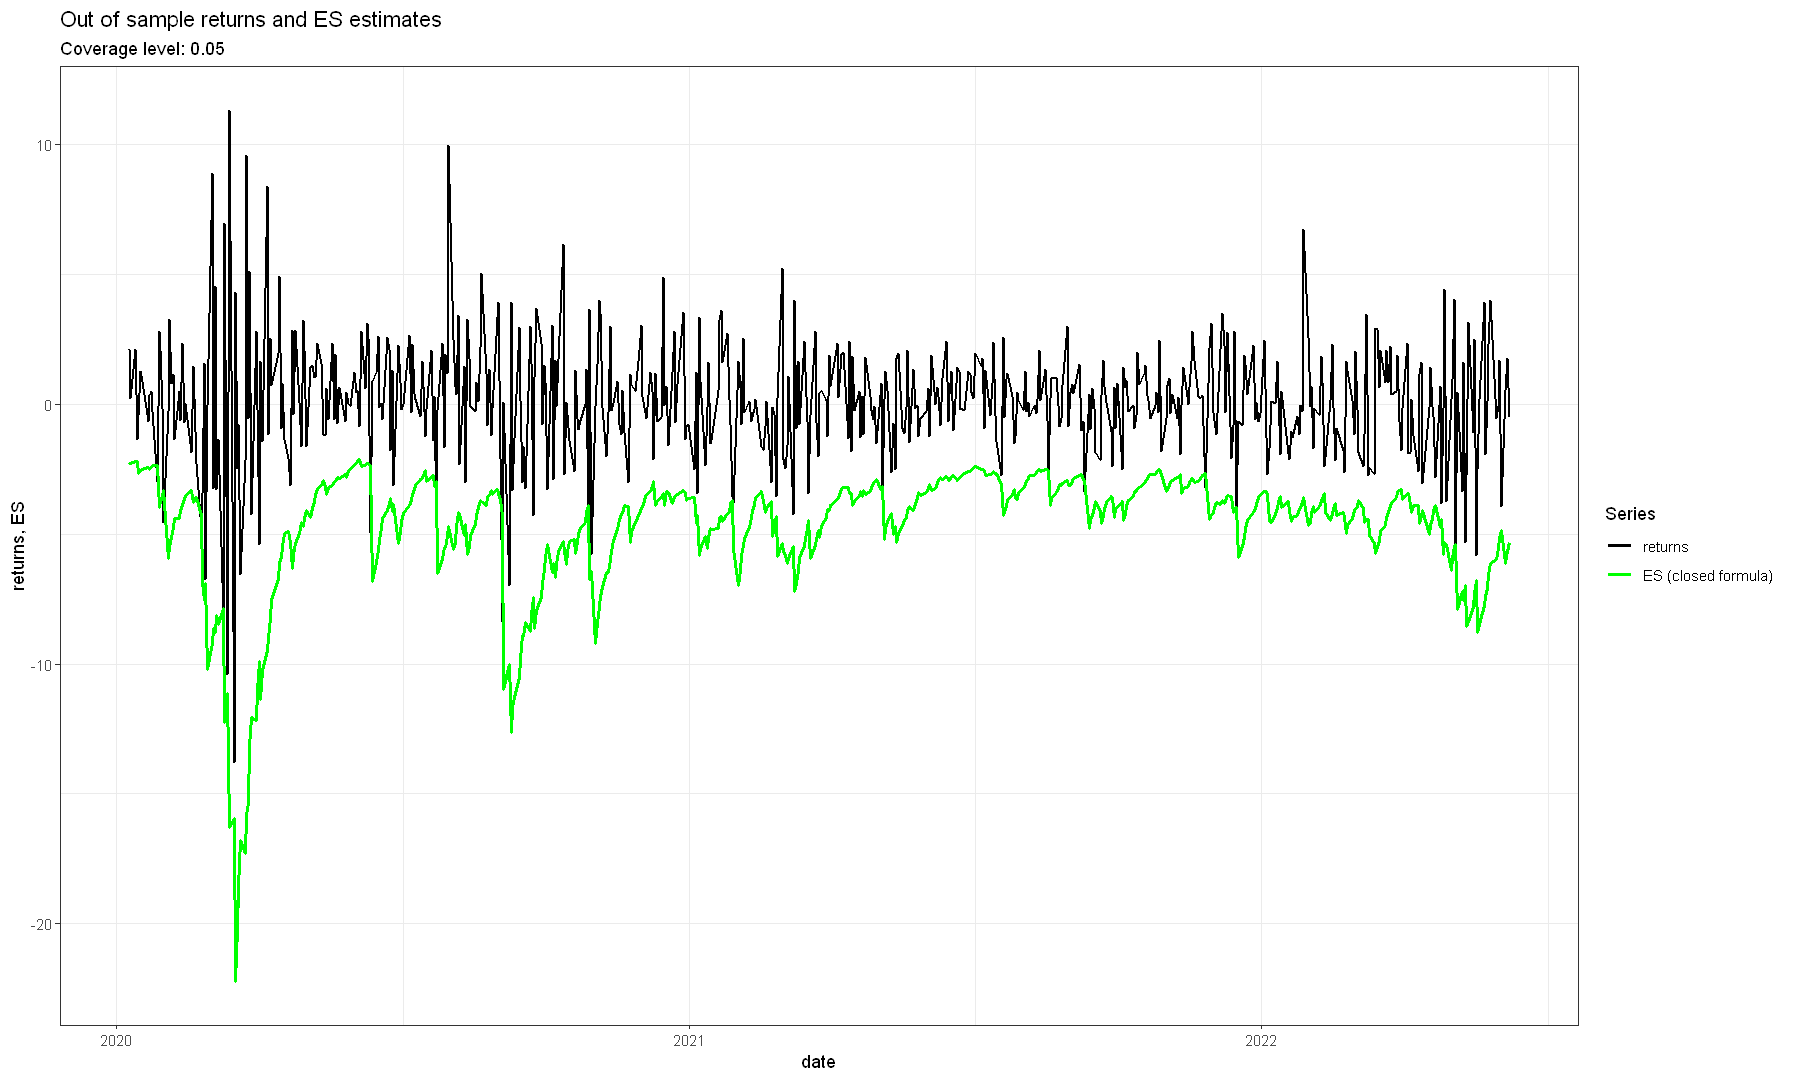

In [10]:
labels <- c("returns" = "black","ES (closed formula)" = "green")
ffigure <- ggplot(OOSdf, aes(x = Date)) +
  geom_line(aes(y = ret, color="returns"), linetype = "solid", size = 0.8) +
  geom_line(aes(y = ES, color="ES (closed formula)"), linetype = "solid", size = 1) +
  labs(title = "Out of sample returns and ES estimates",
       subtitle = paste0("Coverage level: ", alpha),
       #caption = " ",
       color = "Series",
       x = "date",
       y = "returns, ES") +
  scale_color_manual(values = labels)
options(repr.plot.width=15, repr.plot.height=9)
ffigure +  theme_bw(base_line_size = 0.1)

## 4. Backtesting
### 4.1.  Unconditional test of Du & Escanciano (2017)

Du and Escanciano's Expected Shortfall backtests are based on cumulative hits. Let $u_t\equiv F(z_t)$, then, the cumulative hit is defined as \begin{eqnarray}
H_t(\alpha)&=&\int_{0}^{\alpha}h_t(u)du\\
H_t(\alpha)&=& \frac{1}{\alpha}(\alpha-u_t)\mathbb{I}(u_t<\alpha),
\end{eqnarray}
 
Since $h_t(u)$ has mean $u$, by Fubini's theorem, $H_t(\alpha)$ has mean $\frac{\alpha}{2}$. The unconditional backtest for ES is a t-test for the null hypothesis $\mathbb{E}(H_t(\alpha)) = \frac{\alpha}{2}$ and is the analogue for ES of the unconditional VaR backtest proposed in Kupiec (1995).

The t-test statistic is \begin{equation} 
U_{ES}=\frac{\sqrt{n}(\overline{H}(\alpha)-\alpha/2)}{\sqrt{\alpha(1/3 - \alpha/4)}},
\end{equation}

where 
- $n$ is the number of out-of-sample observations 
- $\overline{H}(\alpha)=\frac{1}{n}\sum_{t=1}^n \hat{H}_t(\alpha)$ 
- $\hat{H}_t(\alpha)=\frac{1}{\alpha}(\alpha-\hat{u}_t)\mathbb{I}(\hat{u}_t<\alpha)$.

If the estimation period (**in-sample** lenght) is **larger than** the evaluation period (**out-of-sample** lenght), then $U_{ES}\overset{d}{\sim}N(0,1)$. So that, the null hypothesis of a correctly specified model is rejected at the 5% significance level if the absolute value of the test statistic is greater than 1.96.

In [11]:
# Unconditional test of Du & Escanciano (2017)
# H0: the model is correctly specified
zt <- (OOSdf$ret - pardf[,"mu"])/sigmaprime  
ut <- NULL
for (i in 1:OOS){
    ut <- rbind(ut,skewtcdf(zt[i],pardf[i,"nu"],pardf[i,"lambda"]))
}
hit <- OOSdf$ret < OOSdf$VaR  
Hit <- (1/alpha)*(alpha-ut)*(ut<alpha)
Hbar <- mean(Hit)
Ues <- (sqrt(OOS)*(Hbar-alpha/2))/(sqrt(alpha*(1/3-alpha/4)))
pval <- 2*pnorm(-abs(Ues))
print(data.frame("statistic"=round(Ues,4),"p-value"=round(pval,4),"reject_H0"=abs(Ues)>1.96))

  statistic p.value reject_H0
1    1.5221   0.128     FALSE


We do not reject the null hypothesis that the model is correctly specified with a significance level of 5%.

### 4.2. Kratz et al. (2018)
Define $\alpha_j$ by $$\alpha_j = \alpha - \frac{j-1}{N}\alpha,\hspace{0.2cm} j=1,...,N, \hspace{0.2cm} N\in\mathbb{N},$$ for some $\alpha$, with $\alpha_0=1$ and $\alpha_{N+1}=0$.

The idea of a multilevel VaR backtest serving as an implicit backtest of expected shortfall stems naturally from an approximation of ES proposed by Emmer et al. (2015). These authors show that $$ES_t(\alpha) \approx \frac{1}{N}\left(VaR_t(\alpha_1) + ... + VaR_t(\alpha_N) \right)$$

Define the hit indicator of level $\alpha_j$ at time $t$ by $I_{t,j}=\mathbb{I}_{\{r_t<VaR_t(\alpha_j)\}}$, where $\mathbb{I}_{A}$ denotes an event indicator for event $A$. Testing simultaneously VaR estimates at $N$ levels leads to a multinomial distribution. Define $X_t=\sum_{j=1}^{N}I_{t,j}$, then the sequence $(X_t)_{t=1,...,n}$ counts the number of VaR levels that are breached. The sequence $(X_t)$ should satisfy two conditions:
* The unconditional coverage hipothesis, $P(X_j\leq j) = 1-\alpha_j,\hspace{0.2cm} j=0,...,N,\hspace{0.2cm} \text{for all } t$.
* The independence hypothesis, $X_t$ is independent of $X_s$ for $s\neq t$.

Define the cell counts by \begin{equation} O_j = \sum_{t=1}^{n}\mathbb{I}_{\{X_t=j\}}, \hspace{0.2cm} j=0,1,...,N.
\end{equation}

The random vector $(O_0,...,O_N)$ should follow the multinomial distribution $$(O_0,...,O_N) \sim MN(n,(\alpha_0-\alpha_1,...,\alpha_N-\alpha_{N+1})),$$ where $n$ is the number of trials or experiments that we realize (the out-of-sample size in our case). More formally, let $1=\theta_0<\theta_1<...<\theta_N<\theta_{N+1}=0$ be an arbitrary sequence of parameters and consider the model $(O_0,...,O_N) \sim MN(n,(\theta_0-\theta_1,...,\theta_N-\theta_{N+1}))$. We test the null and alternative hypotheses given by \begin{eqnarray} H_0 &:& \theta_j = \alpha_j \hspace{0.2cm} \text{for} \hspace{0.2cm} j=1,...,N\\
H_1 &:& \theta_j \neq \alpha_j \hspace{0.2cm} \text{for at least one }j\in\{1,...,N\}\end{eqnarray}

According to Kratz et al. (2018), three test statistics can be used to evaluate these hypotheses. The test statistic used here is $$\overset{\sim}{S}_N = 2 \sum_{j:0\leq j\leq N,O_j\neq 0} O_j \log\left( \frac{O_j}{n(\alpha_j-\alpha_{j+1})} \right)\overset{d}{\sim} \chi^2_N$$

The null hypothesis is rejected when $\overset{\sim}{S}_N>\chi^2_N$. Under the null hypothesis our estimated model of returns satisfy the unconditional coverage hypothesis and the independence hypothesis, what means that our Expected Shortfall is well estimated.

### N=4

In [ ]:
# Kratz et al. (2018) for N=4
O0 <- sum(OOSdf$ret > VaRdf_N4$VaR1_4)
O1 <- sum(OOSdf$ret < VaRdf_N4$VaR1_4 & OOSdf$ret > VaRdf_N4$VaR2_4)
O2 <- sum(OOSdf$ret < VaRdf_N4$VaR2_4 & OOSdf$ret > VaRdf_N4$VaR3_4)
O3 <- sum(OOSdf$ret < VaRdf_N4$VaR3_4 & OOSdf$ret > VaRdf_N4$VaR4_4)
O4 <- sum(OOSdf$ret < VaRdf_N4$VaR4_4)
 
S4 <- 2 * (O0*log(O0/(OOS*(1-alphaj_4[1]))) + 
           O1*log(O1/(OOS*(alphaj_4[1]-alphaj_4[2]))) + 
           O2*log(O2/(OOS*(alphaj_4[2]-alphaj_4[3]))) +
           O3*log(O3/(OOS*(alphaj_4[3]-alphaj_4[4]))) +
           O4*log(O4/(OOS*(alphaj_4[4]-0)))
          )
 
pval <- 1-pchisq(S4,4)

print(data.frame("statistic"=round(S4,4),"p-value"=round(pval,4),"reject_H0"=S4>qchisq(0.95,4)))

We do not reject the null hypothesis that the model is correctly specified with a significance level of 5%.

In [16]:
print(round(data.frame("alpha_j"=alphaj_4,"alpha_j_hat"=c((OOS-O0)/OOS,(OOS-O0-O1)/OOS,(OOS-O0-O1-O2)/OOS,(OOS-O0-O1-O2-O3)/OOS)),4))

  alpha_j alpha_j_hat
1  0.0500      0.0673
2  0.0375      0.0493
3  0.0250      0.0312
4  0.0125      0.0164


### N=8

In [17]:
# Kratz et al. (2018) for N=8
O0 <- sum(OOSdf$ret > VaRdf_N8$VaR1_8)
O1 <- sum(OOSdf$ret < VaRdf_N8$VaR1_8 & OOSdf$ret > VaRdf_N8$VaR2_8)
O2 <- sum(OOSdf$ret < VaRdf_N8$VaR2_8 & OOSdf$ret > VaRdf_N8$VaR3_8)
O3 <- sum(OOSdf$ret < VaRdf_N8$VaR3_8 & OOSdf$ret > VaRdf_N8$VaR4_8)
O4 <- sum(OOSdf$ret < VaRdf_N8$VaR4_8 & OOSdf$ret > VaRdf_N8$VaR5_8)
O5 <- sum(OOSdf$ret < VaRdf_N8$VaR5_8 & OOSdf$ret > VaRdf_N8$VaR6_8)
O6 <- sum(OOSdf$ret < VaRdf_N8$VaR6_8 & OOSdf$ret > VaRdf_N8$VaR7_8)
O7 <- sum(OOSdf$ret < VaRdf_N8$VaR7_8 & OOSdf$ret > VaRdf_N8$VaR8_8)
O8 <- sum(OOSdf$ret < VaRdf_N8$VaR8_8)
 
S8 <- 2 * (O0*log(O0/(OOS*(1-alphaj_8[1]))) + 
           O1*log(O1/(OOS*(alphaj_8[1]-alphaj_8[2]))) + 
           O2*log(O2/(OOS*(alphaj_8[2]-alphaj_8[3]))) +
           O3*log(O3/(OOS*(alphaj_8[3]-alphaj_8[4]))) +
           O4*log(O4/(OOS*(alphaj_8[4]-alphaj_8[5]))) +
           O5*log(O5/(OOS*(alphaj_8[5]-alphaj_8[6]))) +
           O6*log(O6/(OOS*(alphaj_8[6]-alphaj_8[7]))) +
           O7*log(O7/(OOS*(alphaj_8[7]-alphaj_8[8]))) +
           O8*log(O8/(OOS*(alphaj_8[8]-0)))
          )
 
pval <- 1-pchisq(S8,8)

print(data.frame("statistic"=round(S8,4),"p-value"=round(pval,4),"reject_H0"=S8>qchisq(0.95,8)))

  statistic p.value reject_H0
1    7.3445     0.5     FALSE


We do not reject the null hypothesis that the model is correctly specified with a significance level of 5%.

In [18]:
print(round(data.frame("alpha_j"=alphaj_8,
                       "alpha_j_hat"=c((OOS-O0)/OOS,(OOS-O0-O1)/OOS,(OOS-O0-O1-O2)/OOS,(OOS-O0-O1-O2-O3)/OOS,
                                       (OOS-O0-O1-O2-O3-O4)/OOS,(OOS-O0-O1-O2-O3-O4-O5)/OOS, (OOS-O0-O1-O2-O3-O4-O5-O6)/OOS,
                                       (OOS-O0-O1-O2-O3-O4-O5-O6-O7)/OOS)),4))

  alpha_j alpha_j_hat
1  0.0500      0.0673
2  0.0438      0.0591
3  0.0375      0.0493
4  0.0312      0.0427
5  0.0250      0.0312
6  0.0188      0.0263
7  0.0125      0.0164
8  0.0063      0.0049


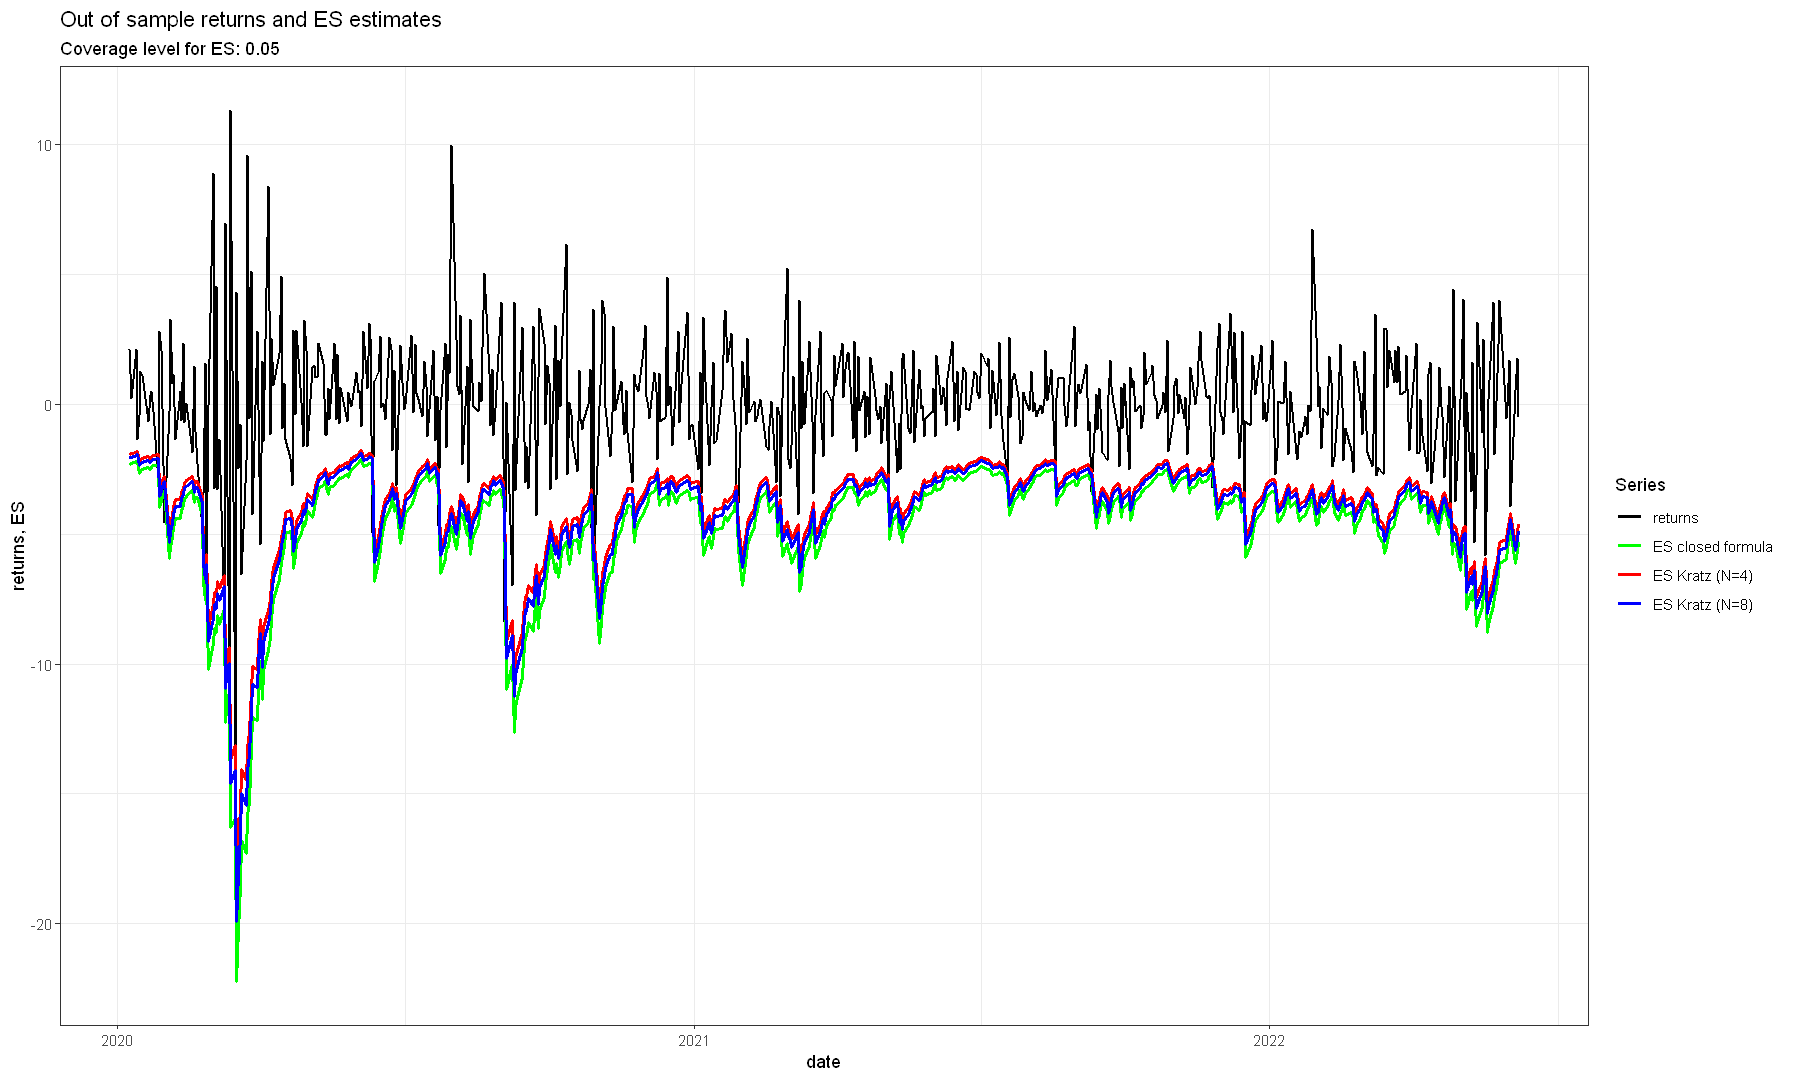

In [20]:
# Approximated ES of Kratz et al. (2018) vs ES of closed formula:
ESkratz4 <- (1/4)*(VaRdf_N4$VaR1_4 + VaRdf_N4$VaR2_4 + VaRdf_N4$VaR3_4 + VaRdf_N4$VaR4_4) # equation (1.1) in Kratz (2018), for N=4
ESkratz8 <- (1/8)*(VaRdf_N8$VaR1_8 + VaRdf_N8$VaR2_8 + VaRdf_N8$VaR3_8 + VaRdf_N8$VaR4_8 + VaRdf_N8$VaR5_8 + VaRdf_N8$VaR6_8 + VaRdf_N8$VaR7_8 + VaRdf_N8$VaR8_8) # equation (1.1) in Kratz (2018), for N=4

ESdf <- data.frame(Date,"ret"=subset(retdf$ret, (retdf$date >= as.Date(retdf$date[T0+1]))),ESkratz4,ESkratz8,ES)
labels <- c("returns" = "black","ES closed formula"="green","ES Kratz (N=4)"="red", "ES Kratz (N=8)"="blue")
ffigure <- ggplot(ESdf, aes(x = Date)) +
  geom_line(aes(y = ret, color="returns"), linetype = "solid", size = 0.8) +
  geom_line(aes(y = ES, color="ES closed formula"), linetype = "solid", size = 1) +
  geom_line(aes(y = ESkratz4, color="ES Kratz (N=4)"), linetype = "solid", size = 1) +  
  geom_line(aes(y = ESkratz8, color="ES Kratz (N=8)"), linetype = "solid", size = 1) + 
  labs(title = "Out of sample returns and ES estimates",
       subtitle = paste0("Coverage level for ES: ", alpha),
       #caption = " ",
       color = "Series",
       x = "date",
       y = "returns, ES") +
  scale_color_manual(values = labels)
options(repr.plot.width=15, repr.plot.height=9)
ffigure +  theme_bw(base_line_size = 0.1)    

Notice that the ES approximation with $N=8$ is better (e.g., closer to the closed formula ES) than the one with $N=4$.

**References:**
*  Du, Z. and Escanciano, J.C. (2017). "Backtesting Expected Shortfall: Accounting for Tail Risk", Management Science, Vol. 63, No. 4, 940-958.
* Emmer, S. , Kratz, M. , Tasche, D. (2015). "What is the best risk measure in practice?", J. Risk 18, 31–60 .
* Hansen, B. E. (1994). “Autoregressive conditional density estimation,” International Economic Review, 705–730.
* Kratz, M., Lok, Y.H. and McNeil, A.J. (2018). "Multinomial VaR backtests: A simple implicit approach to backtesting expected shortfall" Journal of Banking and Finance, 88, 393-407.
* Kupiec, P. H. (1995). “Techniques for Verifying the Accuracy of Risk Measurement Models”, The Journal of Derivatives, 3, 73–84.